# Test detection of water, label 7,8

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import cv2
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
from data_utils import GRID_SIZE, TRAIN_WKT, LABELS, get_resized_polygons, TRAIN_IMAGE_IDS, ALL_IMAGE_IDS
from image_utils import get_image_data, generate_pansharpened, generated_upsampled_swir, generate_label_image
from image_utils import get_common_size, generate_aligned_swir
from visu_utils import display_img_1b, display_img_3b, display_img_8b, display_labels, plt_st
from preprocessing_utils import create_pan_rad_inds_ms, create_pan_ms_swir
from postprocessing_utils import normalize, binarize

Water detection:

In [4]:
from data_utils import get_image_ids
gb = TRAIN_WKT[~TRAIN_WKT['MultipolygonWKT'].str.contains("EMPTY")].groupby('ClassType')
waterway_train = get_image_ids([7,], gb)
standing_water_train = get_image_ids([8,], gb)
standing_water_train = list(set(standing_water_train) - (set(standing_water_train) & set(waterway_train)))
others_train_ids = list((set(TRAIN_IMAGE_IDS) - set(waterway_train)) - set(standing_water_train))
print len(waterway_train), len(standing_water_train), len(others_train_ids)

2 11 12


In [5]:
# from glob import glob
# all_train_ids = glob(os.path.join(TRAIN_DATA, "*.tif"))
# all_train_ids = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_ids if 'mean' not in s and 'std' not in s])
# print "First & last train ids : ", all_train_ids[0], all_train_ids[-1], len(all_train_ids)

In [6]:
l1 = int(len(waterway_train)*0.8)
l2 = int(len(standing_water_train)*0.8)
l3 = int(len(others_train_ids)*0.8)
train_ids = tuple(waterway_train[:l1]) + tuple(standing_water_train[:l2]) + tuple(others_train_ids[:l3])
val_ids = tuple(waterway_train[l1:]) + tuple(standing_water_train[l2:]) + tuple(others_train_ids[l3:])
print len(train_ids), len(val_ids)

assert len(set(waterway_train) - set(train_ids)) > 0, "Bad distribution"
assert len(set(standing_water_train) - set(train_ids)) > 0, "Bad distribution"

18 7


In [7]:
# from image_utils import imwrite, compute_mean_std_on_images
# from geo_utils.GeoImage import GeoImage

# np.random.shuffle(all_train_ids)
# ll = int(len(all_train_ids)*0.8)
# train_ids = all_train_ids[:ll]
# val_ids = all_train_ids[ll:]


# def compute_mean_std(image_type, feature_wise, out_shape):
#     s = ''
#     if feature_wise:
#         s = "_feature_wise"
    
#     mean_fname = os.path.join(TRAIN_DATA, 'mean_%s_image%s.tif' % (image_type, s))
#     std_fname = os.path.join(TRAIN_DATA, 'std_%s_image%s.tif' %  (image_type, s))
#     if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
#         logging.getLogger().setLevel(logging.INFO)
#         mean_image, std_image = compute_mean_std_on_images(train_ids, image_type, feature_wise=feature_wise, out_shape=out_shape)
#         logging.getLogger().setLevel(logging.ERROR)
#         imwrite(mean_fname, mean_image)
#         imwrite(std_fname, std_image)
#     else:
#         mean_image = GeoImage(mean_fname).get_data()
#         std_image = GeoImage(std_fname).get_data()
#     return mean_image, std_image


# img_ms_shape = (860, 860, 8)
# img_rgb_shape = (860*4, 860*4, 3)
# feature_wise = True

# mean_rgb_image, std_rgb_image = compute_mean_std('3b', feature_wise, img_rgb_shape)
# mean_ms_image, std_ms_image = compute_mean_std('ms', feature_wise, img_ms_shape)
        
# print "RGB"    
# print mean_rgb_image.shape, std_rgb_image.shape
# print mean_rgb_image.min(), mean_rgb_image.max(), std_rgb_image.min(), std_rgb_image.max()

# print "MS" 
# print mean_ms_image.shape, std_ms_image.shape
# print mean_ms_image.min(), mean_ms_image.max(), std_ms_image.min(), std_ms_image.max()

# print len(train_ids), len(val_ids)

# logging.getLogger().setLevel(logging.ERROR)

```
Web : Coastal, Blue, Green, Yellow, Red, Red Edge, Near-IR1, Near-IR2
         1       2    3       4      5      6          7        8
         0       1    2       3      4      5          6        7   
```         

In [8]:
from otb_preprocessing import compute_rm_indices_image

In [26]:
a = [1,2,3]
np.argmax(a)

2

In [29]:
from training_utils import normalize_image

user_channels_dict = {
    'red': ('ms', 4),
    'green': ('ms', 2), 
    'blue': ('ms', 1),
    'nir': ('ms', 6),
    'mir': ('ms', 7)
}
channels = ['ndwi2', 'ndpi', 'mndwi', 'ci']
rad_indc_shape = (256, 256, 4)
labels = np.array([7,8])

def generate_images(image_ids_to_use, batch_size):
    while True:        
        X = np.zeros((batch_size, rad_indc_shape[2]) + rad_indc_shape[:2], dtype=np.float32)
        Y = np.zeros((batch_size, len(labels)) + rad_indc_shape[:2], dtype=np.float32)        
        counter = 0
        
        total_class_freq = list([0]*(len(labels)+1))
        
        for image_id in image_ids_to_use:     

            if np.sum(total_class_freq) > 0:
                ind = 0 if image_id in waterway_train else 1 if image_id in standing_water_train else 2
                if np.argmax(total_class_freq) == ind:
                    continue
                total_class_freq[ind] += 1
            
            rad_indcs_img = compute_rm_indices_image(image_id, channels, user_channels_dict).astype(np.float32)
            # inverse ndpi
            ndpi = rad_indcs_img[:,:,channels.index('ndpi')]
            rad_indcs_img[:,:,channels.index('ndpi')] = ndpi.max() + ndpi.min() - ndpi
            rad_indcs_img = cv2.resize(rad_indcs_img, dsize=rad_indc_shape[:2], interpolation=cv2.INTER_CUBIC)
            
            img_label = get_image_data(image_id, 'label')[:,:,labels]            
            img_label = cv2.resize(img_label, dsize=rad_indc_shape[:2], interpolation=cv2.INTER_LINEAR)
                        
            # Random flips:
            r = np.random.rand()
            code = None
            if r < 0.3:
                code = 0 # x-axis
            elif r < 0.6:
                code = 1 # y-axis
            elif r < 0.90:
                code = -1 # x,y                 
            if code is not None:
                rad_indcs_img = cv2.flip(rad_indcs_img, code) 
                img_label = cv2.flip(img_label, code)                
            
            if len(img_label.shape) == 2:
                img_label = img_label[:,:,None]
                        
                            
            h, w, _ = rad_indcs_img.shape
            X[counter,:,:h,:w] = rad_indcs_img.transpose([2,0,1])
            h, w, _ = img_label.shape
            Y[counter,:,:h,:w] = img_label.transpose([2,0,1])
            
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0


(5, 4, 256, 256) (5, 2, 256, 256)
-0.625133 0.552436 0.0 1.0


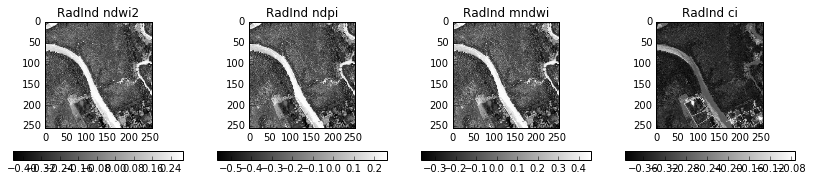

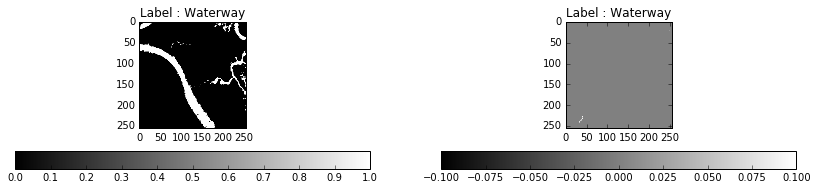

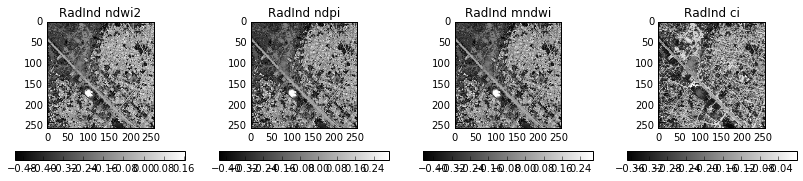

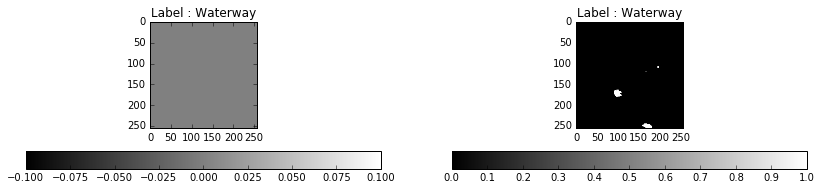

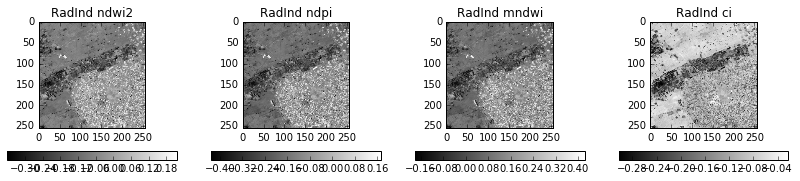

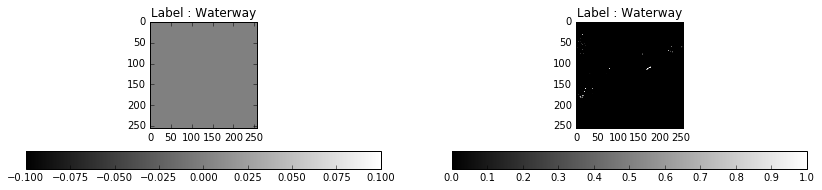

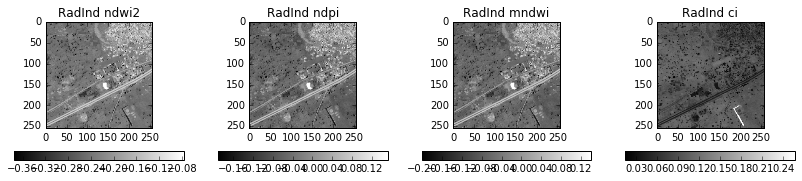

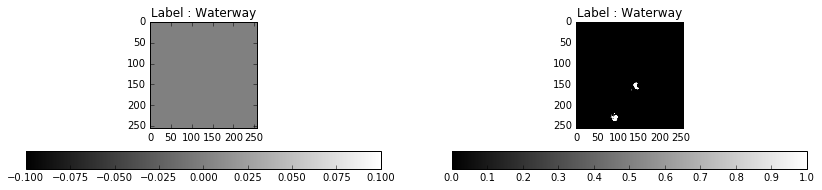

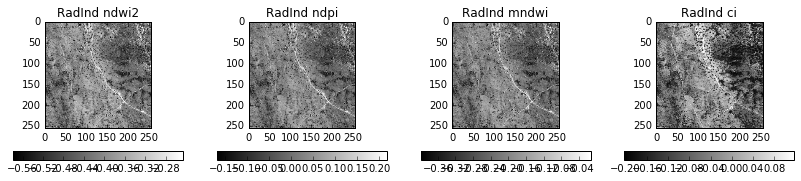

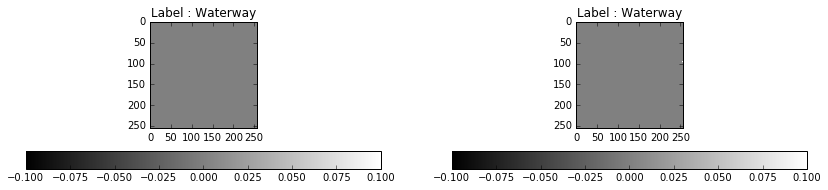

In [31]:
batch_size = 5
for X, Y in generate_images(train_ids, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    for i in range(batch_size):
        
        plt.figure(figsize=(14, 6))        
        m = 4
        n = int(X.shape[1] * 1.0 / m + 1.0)
        for j in range(X.shape[1]):
            plt.subplot(n,m,j+1)
            display_img_1b(X[i,j,:,:])
            plt.title("RadInd %s" % channels[j])
            
        plt.figure(figsize=(14, 6))   
        m = 2 
        n = int(Y.shape[1] * 1.0 / m + 1.0)
        for j in range(Y.shape[1]):
            plt.subplot(n,m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[0]])

    break

In [32]:
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from another_unet import unet

In [33]:
model = unet(len(labels), len(channels), rad_indc_shape[1], rad_indc_shape[0])
weights_filename = os.path.join("weights", "water_detection_78.h5")

In [34]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 4, 256, 256)   0                                            
____________________________________________________________________________________________________
convolution2d_31 (Convolution2D) (None, 64, 128, 128)  2368        input_3[0][0]                    
____________________________________________________________________________________________________
leakyrelu_15 (LeakyReLU)         (None, 64, 128, 128)  0           convolution2d_31[0][0]           
____________________________________________________________________________________________________
convolution2d_32 (Convolution2D) (None, 128, 64, 64)   73856       leakyrelu_15[0][0]               
___________________________________________________________________________________________

In [35]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)

In [ ]:
opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [ ]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 512
nb_val_samples = 64


print batch_size, samples_per_epoch, nb_val_samples
try:
    history = model.fit_generator(
        generate_images(train_ids, batch_size),
        samples_per_epoch=samples_per_epoch, 
        nb_epoch=10,
        validation_data=generate_images(val_ids, batch_size),
        nb_val_samples=nb_val_samples,
        callbacks=[model_checkpoint],
        verbose=1
    )
except KeyboardInterrupt:    
    model.save_weights(weights_filename)


4 512 64


In [ ]:
def score(y_true, y_pred):
    smooth = 1e-12
    if len(y_true.shape) == 2: 
        y_true = y_true[:,:,None]    
    if len(y_pred.shape) == 2: 
        y_pred = y_pred[:,:,None]        
    y_true = y_true.astype(np.float32)
    y_pred = y_pred.astype(np.float32)
    intersection = np.sum(y_true * y_pred, axis=(0, 1))
    sum_ = np.sum(y_true + y_pred, axis=(0, 1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)